In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7287 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Chickenpox', 'Healthy skin', 'Measles', 'Monkeypox', 'Small_Pox']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 0 4 1 0 4 3 3 3 4 0 3 4 4 4 1 4 3 3 4 4 1 3 3 3 0 3 4 4 4 4 0]


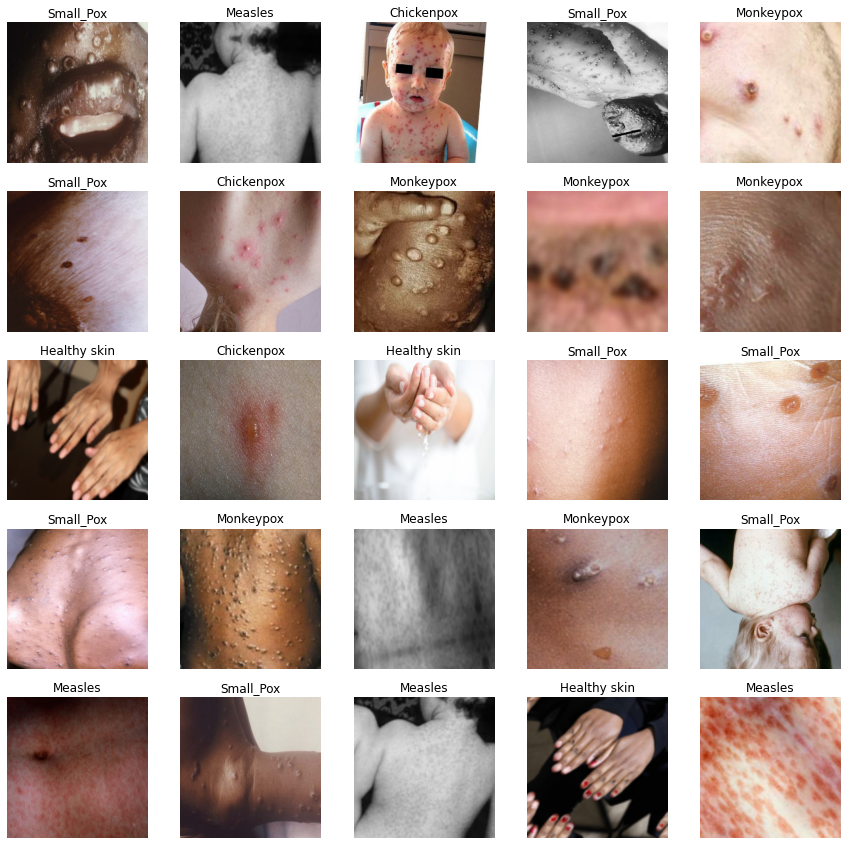

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

228

In [10]:
train_size = 0.8
len(dataset)*train_size

182.4

In [11]:
train_ds = dataset.take(182)
len(train_ds)

182

In [12]:
test_ds = dataset.skip(182)
len(test_ds)

46

In [13]:
val_size=0.1
len(dataset)*val_size

22.8

In [14]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [15]:
test_ds = test_ds.skip(22)
len(test_ds)

24

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

182

In [19]:
len(test_ds)

24

In [20]:
len(val_ds)

22

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 223, 223, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 110, 110, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 55, 55, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 54, 54, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
182/182 [==============================] - 127s 657ms/step - loss: 1.4718 - accuracy: 0.3333 - val_loss: 1.3273 - val_accuracy: 0.4616
Epoch 2/100
182/182 [==============================] - 108s 593ms/step - loss: 1.2763 - accuracy: 0.4767 - val_loss: 1.1841 - val_accuracy: 0.5312
Epoch 3/100
182/182 [==============================] - 113s 618ms/step - loss: 1.1391 - accuracy: 0.5470 - val_loss: 1.2225 - val_accuracy: 0.5114
Epoch 4/100
182/182 [==============================] - 110s 601ms/step - loss: 1.0344 - accuracy: 0.5893 - val_loss: 0.9855 - val_accuracy: 0.5895
Epoch 5/100
182/182 [==============================] - 110s 605ms/step - loss: 0.9523 - accuracy: 0.6291 - val_loss: 0.8223 - val_accuracy: 0.6960
Epoch 6/100
182/182 [==============================] - 113s 623ms/step - loss: 0.8475 - accuracy: 0.6855 - val_loss: 0.9173 - val_accuracy: 0.6648
Epoch 7/100
182/182 [==============================] - 117s 640ms/step - loss: 0.7736 - accuracy: 0.7188 - val_loss: 0

In [29]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 10s 132ms/step - loss: 0.2315 - accuracy: 0.9401


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

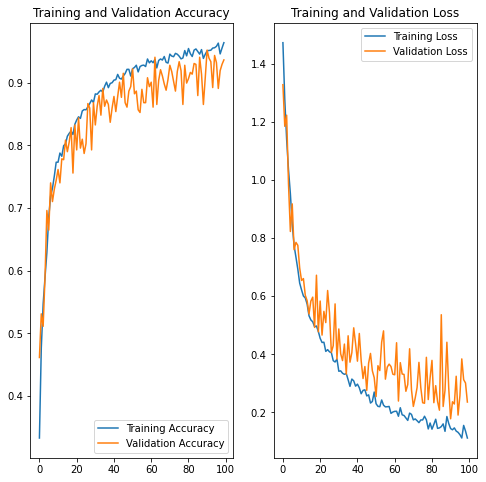

In [31]:
EPOCHS=100
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


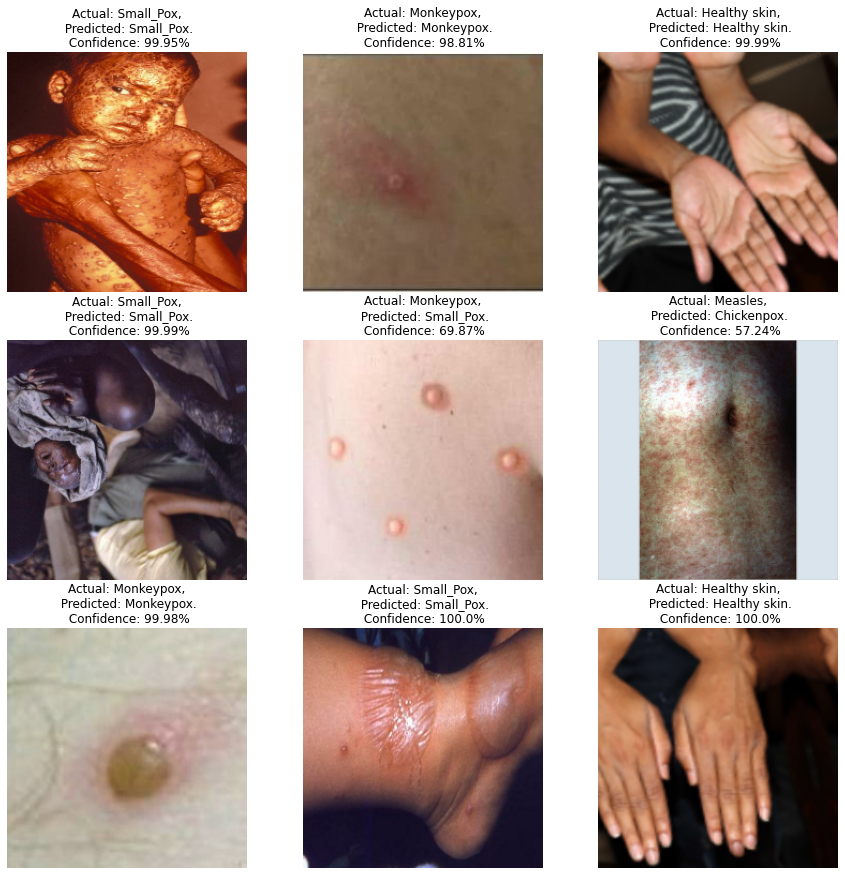

In [37]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
model.save('basic_cnn.h5')

NameError: name 'basic_cnn' is not defined